# Exploratory Data Analysis - Distribution of Rationales
> Prototyping D: Code Completion

This notebook concentrates on analyzing the distribution of rationale probabilities across different datasets. Experiment [1.4.0.1] investigates this distribution using Level_0 clustering, whereas Experiment [1.4.0.3] focuses on Level_1 clustering.
- **Level 0**: correspond to the tag assigned to rationales and target tokens, derived directly form the Grammar in tree-sitter and nltk. 
- **Level 1**: Rationales and target tokens are grouped according to the initial taxonomy defined in our paper.

*Notebook Structure*
- Notebook parameters
- Source Code
    - Imports
    - Data Loading
    - Data processing
- Experiment [1.4.0.1]
- Experiment [1.4.0.3]

*General Instructions*
* Collapse cells by tittle to improve the navigation
* Before running the experiments, it is required to have global_ast_results with the level_0 aggragation reuslts of each dataset.
* Read description on each experiment for further instructions

In [1]:
def param_default():
    return {
        'model': 'codeparrot',
        'modality' : 'nl_sc',
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        ######## INPUT
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results',
        'grouping_results': '/workspaces/code-rationales/data/experiments/grouping_results', 
        ######## OUTPUT
        'rationales_distributions': '/workspaces/code-rationales/data/experiments/rationales_distributions',
        'num_experiments': 30,
        'num_samples': 100,
    }
    
params = param_default()

## Source Code

### Imports

In [2]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
import json
import os.path
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

### Data Loading

In [3]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [4]:
def load_ast_rationales_results(dataset_id: str) :
    experiment_paths = [get_experiment_path(params['global_ast_results'] + '/' + params['model'] + '/' + params['modality'], params['datasets'][dataset_id], exp) for exp in range(params['num_experiments'])]
    experiment_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_results.append(json.loads(file.read()))
    return experiment_results

In [5]:
def load_rationales_results(dataset_id: str, level: str) :
    file_path = params['grouping_results'] + '/' + params['model'] + '/' + params['modality'] + '/' + params['datasets'][dataset_id] + '_' + level + '.json'
    with open(file_path, 'r') as file:
        return json.loads(file.read())

### Data processing

In [6]:
def flat_rationales_probabilities(rationales_results):
    dataset_rationales_values = []
    for experiment_result in rationales_results:
        for target_key, target_values in experiment_result.items():
            for rational_key, rational_values in target_values.items():
                dataset_rationales_values = dataset_rationales_values + rational_values
    return dataset_rationales_values

In [7]:
def get_rationales_distribution(dataset_id: str, level: str, experiments: int):
    rationales_results = load_ast_rationales_results(dataset_id)[:experiments] if level == 'level_0' else load_rationales_results(dataset_id, level)[:experiments]
    dataset_rationales_values = flat_rationales_probabilities(rationales_results)
    return dataset_rationales_values

In [8]:
def create_df_rationales_distributions(level, exp):
    file_path = params['rationales_distributions'] + '/' + params['model'] + '/' + params['modality'] + '/' + level + '_exp_' + str(exp) + '.csv'
    if os.path.isfile(file_path):
          plot_data = pd.read_csv(file_path, index_col=[0])
          return plot_data

    rationales_distributions = {key: [] for key in params['datasets'].keys()}
    for dataset_id in params['datasets'].keys():
        rationales_distributions[dataset_id] = get_rationales_distribution(dataset_id, level, exp)

    group = []
    for dataset_id, distribution in rationales_distributions.items():
        group += [dataset_id]*len(distribution)
    plot_data = {
        'Values': np.concatenate(list(rationales_distributions.values())),
        'Dataset': group
    }
    plot_data = pd.DataFrame(plot_data)
    plot_data.to_csv(file_path)
    return plot_data


## Experiment [1.4.0.1]
**Level 0 rationales distribution plots**

*Research Question: How is the distribution of level_0 rationales probabilities accross datasets?*

General Instructions: Execute this experiment per dataset separately
- Change ```model``` in ```param_default```, indicating the name of the model used for inference
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: create dataframe with distribution of rationales
- Iterates over the aggregation results of rationales using Level_0 for all datasets.
- For each dataset, collects a list of all rationales probabilities, regardless of their type. Given that there are 30 executions in total per dataset, only the results from the first execution are collected.
- Creates a dataframe that includes the dataset IDs along with their corresponding extracted list of rationales probabilities.

In [9]:
df_rationales_distributions_level_0 = create_df_rationales_distributions('level_0',1)

#### Step 2: Creates a Cumulative Distribution Plot

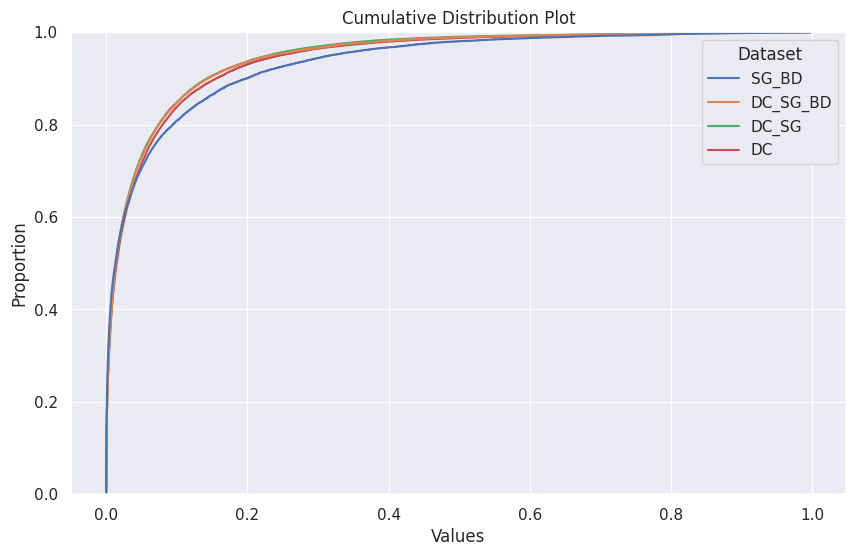

In [10]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_rationales_distributions_level_0, x='Values', hue='Dataset', stat='proportion')
plt.title('Cumulative Distribution Plot')
plt.show()

#### Step 3: Creates a Distribution Plot

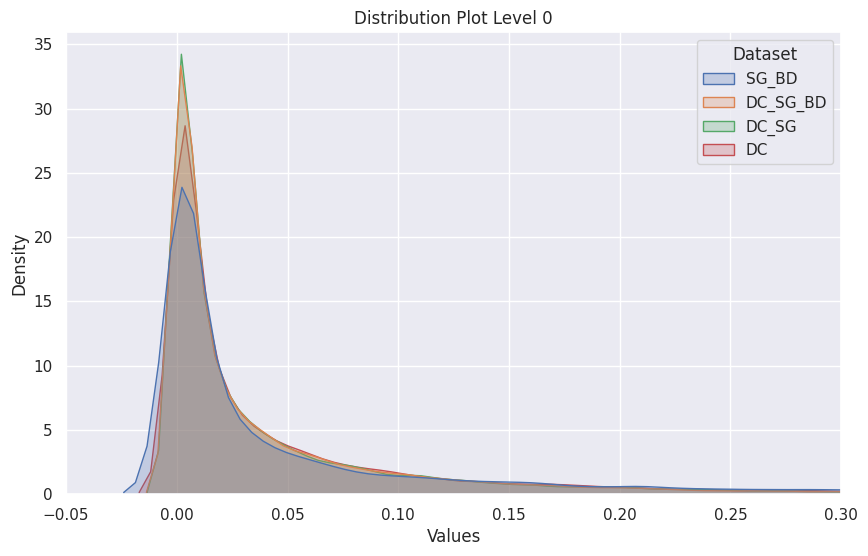

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_rationales_distributions_level_0, x='Values', hue='Dataset', common_norm=False, fill=True)
plt.title('Distribution Plot Level 0')
plt.xlim(-0.05,0.3)
plt.show()

#### Step 4: Prints distributions' statistical data

In [12]:
pd.set_option('display.float_format', lambda x: '%7f' % x)
df_rationales_distributions_level_0[df_rationales_distributions_level_0['Dataset'] == 'DC_SG'].describe()

,Values
count,5488422.000000
mean,0.051656
std,0.099452
min,0.000000
25%,0.002335
50%,0.013613
75%,0.055075
max,0.997882


### Prototyping results
The following subsections show the generated *level_0* cdf for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'modality'```

### Results



#### Modality SC
![level_0_rationales_distributions.jpg](captures/distributions/sc/level_0_rationales_distributions.jpg)

## Experiment [1.4.0.3]
**Level 1 rationales distribution plots**

*Research Question: How is the distribution of level_0 rationales probabilities accross datasets?*

General Instructions: Execute this experiment per dataset separately
- Change ```model``` in ```param_default```, indicating the name of the model used for inference
- Change ```modality``` in ```param_default```, indicating the id of the modality in the prompt

### Prototyping Methodology
Here we expose the step by step to run this experiment.

#### Step 1: create dataframe with distribution of rationales
- Iterates over the aggregation results of rationales using Level_1 for all datasets.
- For each dataset, collects a list of all rationales probabilities, regardless of their type. Given that there are 30 executions in total per dataset, only the results from the first execution are collected.
- Creates a dataframe that includes the dataset IDs along with their corresponding extracted list of rationales probabilities.

In [13]:
df_rationales_distributions_level_1 = create_df_rationales_distributions('level_1',1)

#### Step 2: Creates a Cumulative Distribution Plot

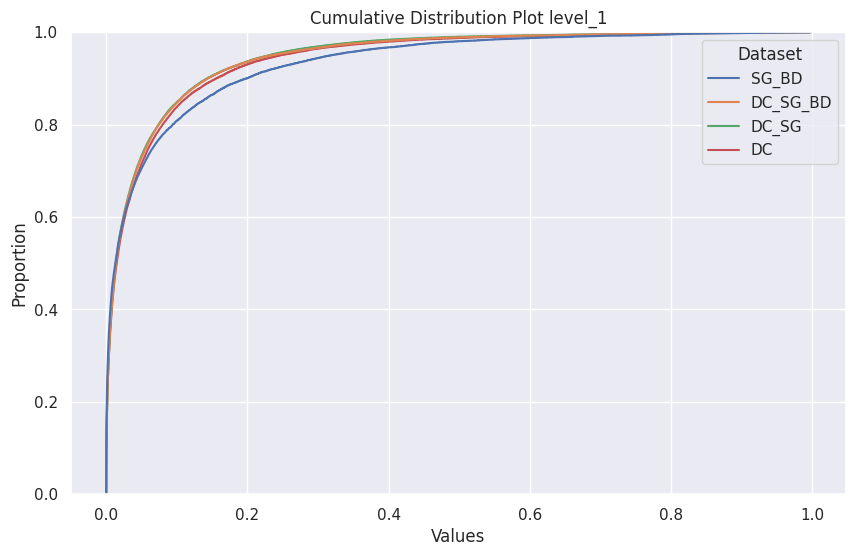

In [14]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_rationales_distributions_level_1, x='Values', hue='Dataset', stat='proportion')
plt.title(f'Cumulative Distribution Plot level_1')
plt.show()

#### Step 3: Creates a Distribution Plot

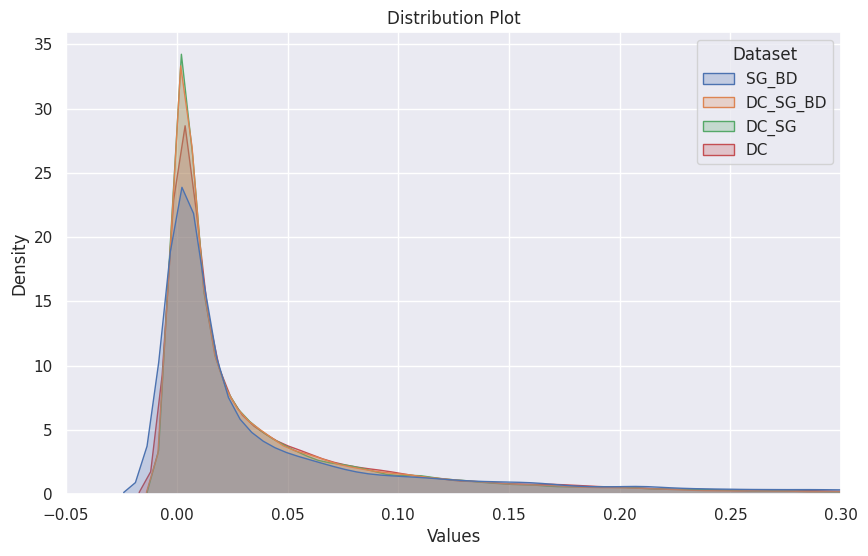

In [15]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_rationales_distributions_level_1, x='Values', hue='Dataset', common_norm=False, fill=True)
plt.title('Distribution Plot')
plt.xlim(-0.05,0.3)
plt.show()

#### Step 4: Prints distributions' statistical data

In [16]:
pd.set_option('display.float_format', lambda x: '%7f' % x)
df_rationales_distributions_level_1[df_rationales_distributions_level_1['Dataset'] == 'DC_SG_BD'].describe()

,Values
count,5527756.000000
mean,0.052721
std,0.101857
min,0.000000
25%,0.002357
50%,0.013770
75%,0.056438
max,0.995721


### Prototyping results
The following subsections show the generated *level_1* cdf for all the four datasets, in the two modalitites. 
To generate the plots from scrach, please modify the following parameters in ```param_default``` at the beginning of the notebook and run the notebook until this point. 
- ```'model'```
- ```'modality'```

### Results


#### Modality SC
![level_1_rationales_distributions.jpg](captures/distributions/sc/level_1_rationales_distributions.jpg)